In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import Reshape, MaxPool2D, Conv2D, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

import os
from io import BytesIO
from PIL import Image

# Data preparation

1. Load MNIST dataset.
2. Flatten and feature-scale it.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = 28
x_train = np.reshape(x_train, [-1, image_size**2]).astype('float32') / 255
x_test = np.reshape(x_test, [-1, image_size**2]).astype('float32') / 255

3. Prepare several images for demonstration of great photomosaics.

In [4]:
def my_scale(ar):
    """ Feature scale an np.array. """

    ar = ar.astype('float32')
    return (ar - ar.min()) / (ar.max() - ar.min())

In [5]:
# We process these images by turning them into a black & white form and feature scaling. 

folder_address = "/content/drive/MyDrive/machine_learning/photomosaics"
file_names = ["man.jpg", "woman.jpg", "me.jpg", "sunset.jpg", "dalmatian.jpg"]
image_names = ["man", "woman", "me", "sunset", "dalmatian"]
labels = ['bearded man', 'long-haired woman', 'yours truly', 'sunset and clouds', 'dalmatian puppy']
rgb_weights = [0.2989, 0.5870, 0.1140]

pics = dict()
color_pics = dict()

for i in range(len(file_names)):
    pic = Image.open(os.path.join(folder_address, file_names[i]))
    pix = np.array(pic.getdata()).reshape(pic.size[1], pic.size[0], 3)
    im = my_scale(np.dot(pix, rgb_weights))
    color_pics[image_names[i]] = pix
    pics[image_names[i]] = im

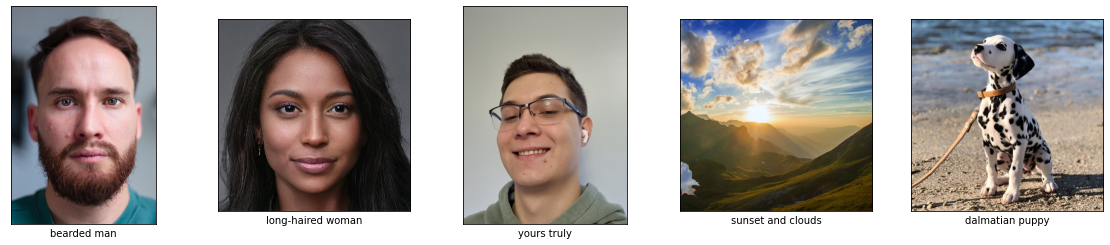

In [6]:
fig, ax = plt.subplots(1, len(image_names), figsize=(4 * len(image_names), 4))

for i in range(len(file_names)):
    ax[i].axes.xaxis.set_ticks([])
    ax[i].axes.yaxis.set_ticks([])
    ax[i].set(xlabel=labels[i])
    ax[i].imshow(color_pics[image_names[i]], cmap='gray')

# Useful functions for visualization (designed specifically for MNIST-type data)

In [7]:
def plot_2d_latent_distribution(model, x_data, y_data, figsize=(10, 10), axes=(0, 1)):
    """
    Plot the distribution of digits from MNIST-type (<x_data>, <y_data>) in the 2d latent space
    of a given autoencoder <model> or its projection to a 2d space.

    Note:
        Latent space must have at least two dimensions.

    Args:
        model (MyConvAutoencoder): Autoencoder model.
        x_data (np.array): np.array of shape (?, 784) containing MNIST-type images.
        y_data (np.array): np.array of shape (?,) containing corresponding digits.
        figsize (tuple, optional): Parameters for the size of the resulting plot. 
            Defaults to (10, 10).
        axes (tuple, optional): Indices of axes to plot the distribution along. Defaults to (0, 1).
    
    Plots:
        Scatter plot of the distribution in the 2d latent space.
    
    """
    
    ax1, ax2 = axes
    latent = model.encoder.predict(x_data)
    colors = ['darkred', 'peru', 'gold', 'lightgreen', 'aqua', 'darkorange', 'slategray', 'navy',
              'darkviolet', 'deeppink']
    symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.ylim(0.0, 1.07)
    for digit in range(10):
        mask = (y_data == digit)
        ax.scatter(latent[mask, ax1], latent[mask, ax2], s=1, 
                   color=colors[digit], label=symbols[digit])

    plt.legend(loc='upper center', ncol=10)
    plt.axis('off')
    plt.show()

In [8]:
def plot_random_samples(model, x_data, n_samples=5, seed=None, size_coef=2):
    """
    Plot <n_samples> random images from <x_data> and their restored versions via a given <model>.

    Args:
        model (MyConvAutoencoder): Autoencoder model.
        x_data (np.array): np.array of shape (?, 784) containing MNIST-type images.
        n_samples (int, optional): Number of samples to show. Defaults to 5.
        seed (:obj:`int`, optional): Seed for random. Defaults to None. 
        size_coef (float, optional): Scaling coefficient for figsize. Defaults to 2.

    Plots:
        A row of original images and restored ones below.

    """

    fig, ax = plt.subplots(2, n_samples, figsize=(size_coef * n_samples, size_coef * 2))
    if seed is not None:
        np.random.seed(seed)
    indices = np.random.randint(0, x_data.shape[0], (n_samples,))
    preds = model.predict(x_data[indices])

    for i in range(n_samples):
        ind = indices[i]
        ax[0, i].axes.xaxis.set_ticks([])
        ax[0, i].axes.yaxis.set_ticks([])
        ax[0, i].imshow(x_data[ind].reshape([28, 28]), cmap='gray')
        ax[1, i].axes.xaxis.set_ticks([])
        ax[1, i].axes.yaxis.set_ticks([])
        ax[1, i].set(xlabel= f'image #{ind}')
        ax[1, i].imshow(preds[i].reshape([28, 28]), cmap='gray')
    
    ax[0, 0].set(ylabel='original')
    ax[1, 0].set(ylabel='restored')
    
    plt.show()

# Model definition and training

It might take several attemps to train the right model for your data. The good news is that once you get it, it works unspeakably well.

In [ ]:
class MyConvAutoencoder(tf.keras.Model):
    '''
    Autoencoder consisting of a CNN encoder and a CNN decoder.  

    Attributes:
        latend_dim (int): Dimension of the latent space.
        reg_std (float, optional): Std for GaussianNoise layer during training. Defaults to 0.001. 
        encoder (tf.keras.Sequential): CNN encoder.
        decoder (tf.keras.Sequential): CNN decoder.

    '''

    def __init__(self, latent_dim):
        super(MyConvAutoencoder, self).__init__(name="my_conv_autoencoder")
        
        self.latent_dim = latent_dim
        # self.reg_std = reg_std

        self.encoder = tf.keras.Sequential([
            Reshape((28, 28, 1), input_shape=(28**2,)),
            Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
            # Conv2D(32, kernel_size=1, strides=1, padding='same', activation='relu'),
            MaxPool2D(),
            BatchNormalization(),
            Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
            # Conv2D(64, kernel_size=1, strides=1, padding='same', activation='relu'),
            MaxPool2D(),
            BatchNormalization(),
            Flatten(),
            Dense(self.latent_dim, activation='sigmoid')
        ], name="my_encoder")

        self.decoder = tf.keras.Sequential([
            Dense(3136, input_shape=(self.latent_dim,), activation='relu'),
            Reshape((7, 7, 64)),
            BatchNormalization(),
            Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
            BatchNormalization(),
            Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
            Flatten()
        ], name="my_decoder")

    def call(self, inputs, training=False):
        latent = self.encoder(inputs)
        if training:
            latent = GaussianNoise(stddev=0.001)(latent)
        outputs = self.decoder(latent)
        return outputs

In [ ]:
tf.random.set_seed(1991) # 1789 - good, 1991 - best (I use years from History for seeds.)
autoencoder = MyConvAutoencoder(latent_dim=2)

autoencoder.compile(
    optimizer="adam", 
    loss="mse",
    metrics=["mae"]
)

In [ ]:
autoencoder.fit(x_train, x_train, epochs=100, batch_size=1024,
                validation_data=(x_test, x_test))

Epoch 1/100
59/59 [==============================] - 2s 26ms/step - loss: 0.1583 - mae: 0.3515 - val_loss: 0.1759 - val_mae: 0.4108
Epoch 2/100
59/59 [==============================] - 1s 23ms/step - loss: 0.1008 - mae: 0.2433 - val_loss: 0.1243 - val_mae: 0.3305
Epoch 3/100
59/59 [==============================] - 1s 23ms/step - loss: 0.0862 - mae: 0.1970 - val_loss: 0.1052 - val_mae: 0.2877
Epoch 4/100
59/59 [==============================] - 1s 23ms/step - loss: 0.0790 - mae: 0.1724 - val_loss: 0.0976 - val_mae: 0.2666
Epoch 5/100
59/59 [==============================] - 1s 23ms/step - loss: 0.0762 - mae: 0.1619 - val_loss: 0.0974 - val_mae: 0.2626
Epoch 6/100
59/59 [==============================] - 1s 23ms/step - loss: 0.0745 - mae: 0.1556 - val_loss: 0.1010 - val_mae: 0.2693
Epoch 7/100
59/59 [==============================] - 1s 23ms/step - loss: 0.0736 - mae: 0.1512 - val_loss: 0.1008 - val_mae: 0.2673
Epoch 8/100
59/59 [==============================] - 1s 23ms/step - loss: 0.

# Analysis of the model

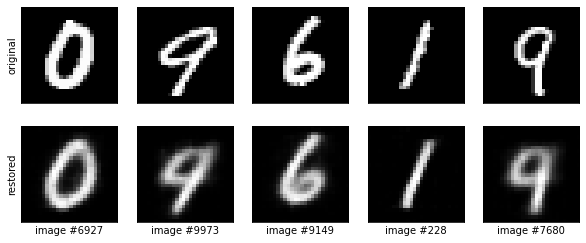

In [ ]:
# Autoencoder provides fairly accurate decodings.
plot_random_samples(autoencoder, x_test, seed=1968)

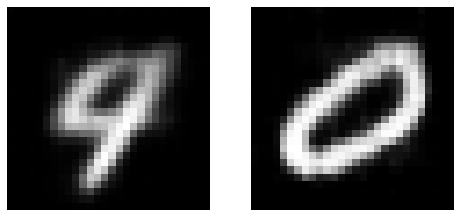

In [ ]:
# Sanity check. Perfectly black tile and white tile decodings.

pred0 = autoencoder.predict(np.zeros((1, image_size**2)))
pred1 = autoencoder.predict(np.ones((1, image_size**2)))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].axis('off')
ax[0].imshow(pred0[0].reshape([image_size, image_size]), cmap='gray')
ax[1].axis('off')
ax[1].imshow(pred1[0].reshape([image_size, image_size]), cmap='gray')
plt.show()

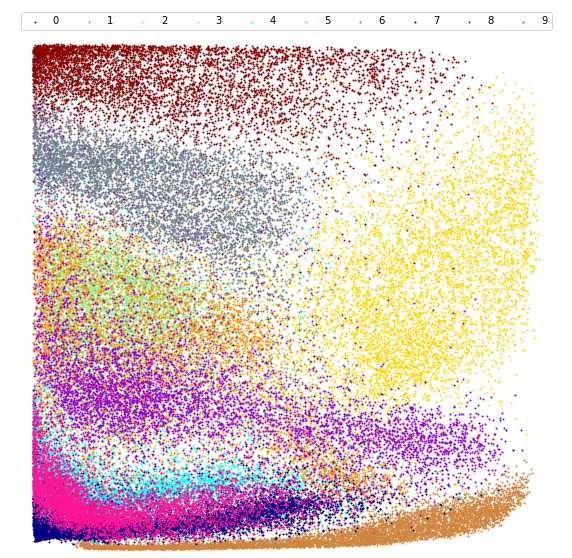

In [ ]:
# Resulting distribution is dense and separates digits quite well. 
plot_2d_latent_distribution(autoencoder, x_train, y_train)

# Definition of the photomosaic filter

In [ ]:
def photomosaic_filter(model, image, strides=(28, 28)):
    """
    Return a photomosaic based on a given image.

    Note:
        Making unequal strides might distort an image.

    Args:
        model (MyConvAutoencoder): Autoencoder model.
        image (np.array): 2d np.array containing a single channel image.
        strides (tuple, optional): Strides for applying autoencoder to tiles. Defaults to (28, 28).
    
    Returns:
        Image consisting of artificially generated tiles, in the form of np.array. 
    
    """

    h, w = image.shape
    h_stride, w_stride = strides
    h_steps, w_steps = (h - 28) // h_stride + 1, (w - 28) // w_stride + 1
    
    tiles = [[image[x * h_stride : x * h_stride + 28, \
                    y * w_stride : y * w_stride + 28].reshape(-1)] \
                    for x in range(h_steps) for y in range(w_steps)]
    tiles = np.concatenate(tiles, axis=0)

    result_image = np.zeros([h_steps * 28, w_steps * 28])
    preds = autoencoder.predict(tiles)
    for x in range(h_steps):
        for y in range(w_steps):
            result_image[x * 28 : (x + 1) * 28, y * 28 : (y + 1) * 28] = \
                preds[x * w_steps + y].reshape([image_size, image_size])

    return result_image

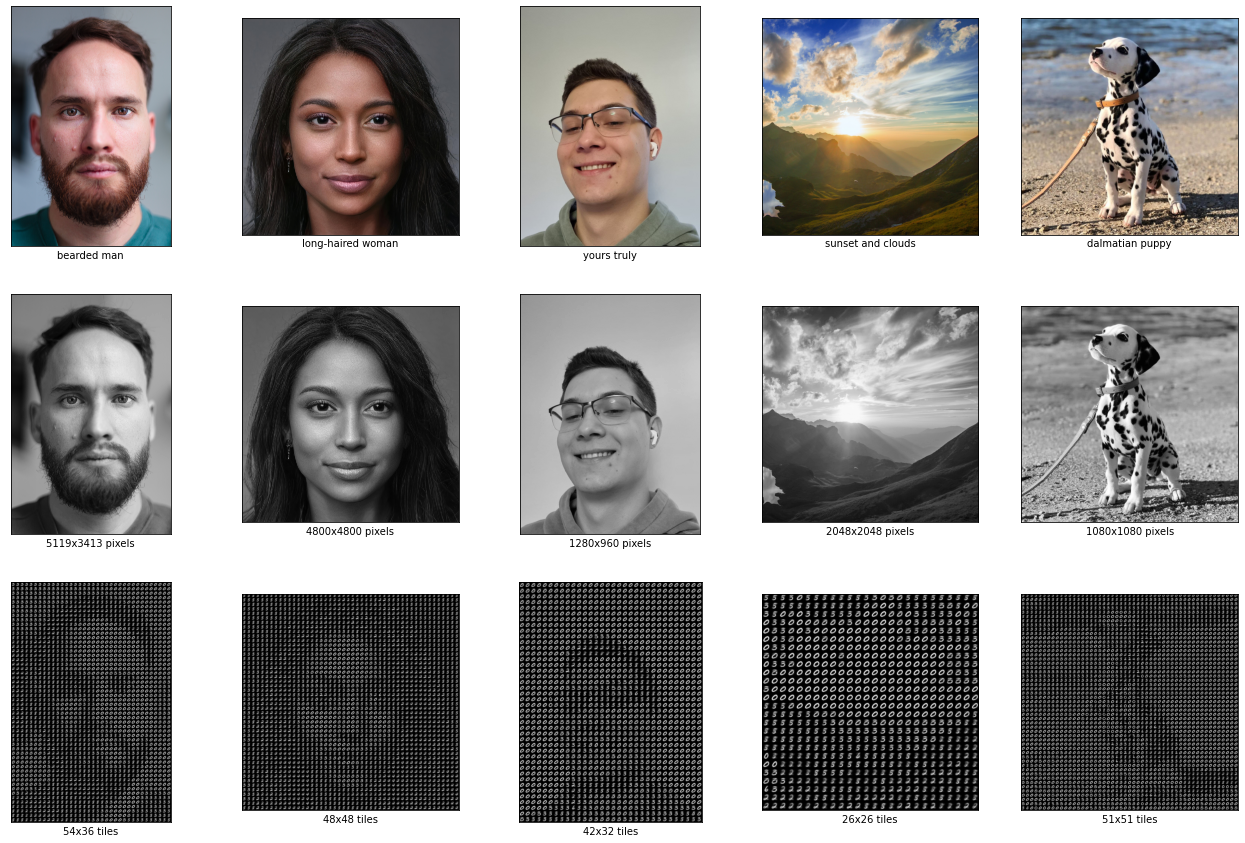

In [ ]:
# Just showing off. If you look from afar all these images look stunning. 

sample_strides = [(96, 96), (100, 100), (30, 30), (80, 80), (21, 21)]
fig, ax = plt.subplots(3, len(file_names), figsize=(4.5 * len(file_names), 15))

for i in range(len(file_names)):
    color_pic = color_pics[image_names[i]]
    original_pic = pics[image_names[i]]
    restored_pic = photomosaic_filter(autoencoder, original_pic, strides=sample_strides[i])
    
    ax[0, i].axes.xaxis.set_ticks([])
    ax[0, i].axes.yaxis.set_ticks([])
    ax[0, i].set(xlabel=labels[i])
    ax[0, i].imshow(color_pic, cmap='gray')
    ax[1, i].axes.xaxis.set_ticks([])
    ax[1, i].axes.yaxis.set_ticks([])
    ax[1, i].set(xlabel=f'{original_pic.shape[0]}x{original_pic.shape[1]} pixels')
    ax[1, i].imshow(original_pic, cmap='gray')
    ax[2, i].axes.xaxis.set_ticks([])
    ax[2, i].axes.yaxis.set_ticks([])
    ax[2, i].set(xlabel=f'{restored_pic.shape[0] // 28}x{restored_pic.shape[1] // 28} tiles')
    ax[2, i].imshow(restored_pic, cmap='gray')

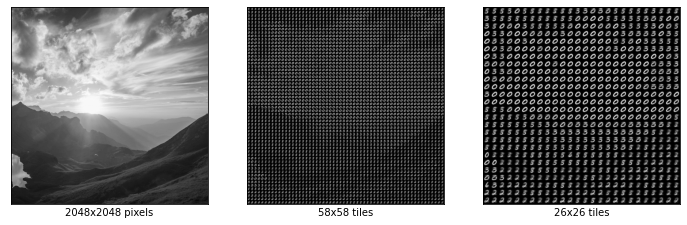

In [ ]:
# This image like no other shows visual capabilities of the autoencoder approach. 

d0 = pics['sunset']
d1 = photomosaic_filter(autoencoder, d0, strides=(35, 35))
d2 = photomosaic_filter(autoencoder, d0, strides=(80, 80))

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].axes.xaxis.set_ticks([])
ax[0].axes.yaxis.set_ticks([])
ax[0].set(xlabel= f'{d0.shape[0]}x{d0.shape[1]} pixels')
ax[0].imshow(pics['sunset'], cmap='gray')
ax[1].axes.xaxis.set_ticks([])
ax[1].axes.yaxis.set_ticks([])
ax[1].set(xlabel= f'{d1.shape[0] // 28}x{d1.shape[1] // 28} tiles')
ax[1].imshow(d1, cmap='gray')
ax[2].axes.xaxis.set_ticks([])
ax[2].axes.yaxis.set_ticks([])
ax[2].set(xlabel= f'{d2.shape[0] // 28}x{d2.shape[1] // 28} tiles')
ax[2].imshow(d2, cmap='gray')
plt.show()

In [ ]:
digitalized_image = photomosaic_filter(autoencoder, pics['me'][250:, 100:-100], strides=(21, 21))

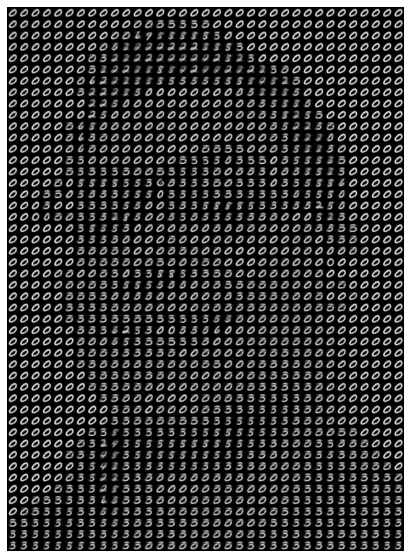

In [ ]:
# Some digits are not quite distinguishable, but it is solvable with a better autoencoder.

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.axis('off')
ax.imshow(digitalized_image, cmap='gray')
plt.show()

# List of versions (they were not uploaded to GitHub, sorry)

In [ ]:
autoencoder.load_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/my_checkpoint_final')

In [ ]:
# Great digits (with tf.seed 1991)
autoencoder.save_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/my_checkpoint_final2')

In [ ]:
# Great colors (lost tf.seed)
autoencoder.save_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/my_checkpoint_final')

In [ ]:
# please be it
autoencoder.save_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/my_checkpoint5')

In [ ]:
# maybe it
autoencoder.save_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/my_checkpoint4')

In [ ]:
# worth submission
autoencoder.save_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/my_checkpoint3')

In [ ]:
# perfect
autoencoder.save_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/my_checkpoint2')

In [ ]:
# alright
autoencoder.save_weights('/content/drive/MyDrive/machine_learning/photomosaics/checkpoints/my_checkpoint1')